
# Basketball Scoring Probabilities (Steph Curry 2022-23)

Project goal: compute the probabilities required for the four presentation slides (Overall Shooting Statistics, Probabilities, Conditional Probabilities - Future, Conditional Probabilities - Retrospective) using the Kaggle Steph Curry 2022-23 shot dataset in `data/stephen_curry_shots_2023.csv`. Each section shows reasoning, calculations, and quick validation notes (V&V) against the project rubric.

**Steps**
1. Load and inspect data to confirm column meanings and data quality.
2. Compute overall shooting/shot-type proportions.
3. Use binomial distribution for forward-looking questions with explicit assumptions.
4. Use conditional probability and Bayes' theorem for future and retrospective questions.
5. Add small visuals to support the slide deck.


In [1]:

# Imports and versions (keep this cell as a quick reproducibility check)
import pandas as pd
import numpy as np
from math import comb
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns

print('pandas', pd.__version__)
print('numpy', np.__version__)
print('scipy', binom.__module__)
print('matplotlib', plt.matplotlib.__version__)


pandas 2.2.2
numpy 1.26.4
scipy scipy.stats._discrete_distns
matplotlib 3.8.4


In [2]:

# Load dataset
DATA_PATH = 'data/stephen_curry_shots_2023.csv'
df = pd.read_csv(DATA_PATH)

# Ensure booleans are parsed as Python bools for clarity
bool_cols = ['result', 'lead']
for col in bool_cols:
    if df[col].dtype == object:
        df[col] = df[col].map({'TRUE': True, 'FALSE': False}).astype(bool)

print(f"Shape: {df.shape}\\nColumns: {list(df.columns)}")
df.head()


Shape: (1434, 15)\nColumns: ['top', 'left', 'date', 'qtr', 'time_remaining', 'result', 'shot_type', 'distance_ft', 'lead', 'player_team_score', 'opponent_team_score', 'opponent', 'team', 'season', 'color']


,top,left,date,qtr,time_remaining,result,shot_type,distance_ft,lead,player_team_score,opponent_team_score,opponent,team,season,color
0,63,300,"Oct 18, 2022",1st Qtr,7:27,False,2,6,True,9,6,LAL,GSW,2023,red
1,133,389,"Oct 18, 2022",1st Qtr,7:22,True,2,17,True,11,6,LAL,GSW,2023,green
2,326,247,"Oct 18, 2022",1st Qtr,7:11,False,3,27,True,11,6,LAL,GSW,2023,red
3,249,89,"Oct 18, 2022",1st Qtr,5:16,False,3,25,True,19,13,LAL,GSW,2023,red
4,282,158,"Oct 18, 2022",1st Qtr,3:52,False,3,24,True,22,17,LAL,GSW,2023,red


In [3]:

# Data quality spot-checks
info = df.dtypes.to_frame('dtype')
missing = df.isna().sum().to_frame('missing')
dupes = df.duplicated().sum()

print('Duplicate rows:', dupes)
display(info.head(10))
display(missing[missing['missing']>0])

# Quick distribution sanity checks
print('\nResult counts:')
print(df['result'].value_counts())
print('\nShot type counts:')
print(df['shot_type'].value_counts())
print('\nQuarter values:', df['qtr'].unique())


Duplicate rows: 0


,dtype
top,int64
left,int64
date,object
qtr,object
time_remaining,object
result,bool
shot_type,int64
distance_ft,int64
lead,bool
player_team_score,int64


,missing



Result counts:
result
False    731
True     703
Name: count, dtype: int64

Shot type counts:
shot_type
3    786
2    648
Name: count, dtype: int64

Quarter values: ['1st Qtr' '2nd Qtr' '3rd Qtr' '4th Qtr' '1st OT']



## Definitions / notation (used in Bayes steps)
- `M` = made shot (`result=True`)
- `~M` = missed shot (`result=False`)
- `T3` = three-point shot (`shot_type=3`)
- `T2` = two-point shot (`shot_type=2`)
- `L` = team had lead (`lead=True`)

From the data we estimate: P(M), P(~M), P(T3), P(T2), P(M ∩ T3), P(M ∩ T2), P(L ∩ T3), P(L ∩ T2), etc.

Bayes / conditional forms used in the notebook:
- P(M | T3) = P(M ∩ T3) / P(T3)
- P(M | T2) = P(M ∩ T2) / P(T2)
- P(T3 | M) = P(M ∩ T3) / P(M)
- P(T2 | M) = P(M ∩ T2) / P(M)


In [4]:

# Overall shooting statistics
n_total = len(df)
counts_result = df['result'].value_counts()
counts_type = df['shot_type'].value_counts()

p_make = counts_result[True] / n_total
p_miss = counts_result[False] / n_total
p_three = counts_type[3] / n_total
p_two = counts_type[2] / n_total

summary = pd.DataFrame({
    'stat': ['P(Make)', 'P(Miss)', 'P(Three-pointer)', 'P(Two-pointer)'],
    'probability': [p_make, p_miss, p_three, p_two],
    'count': [counts_result[True], counts_result[False], counts_type[3], counts_type[2]],
    'n_total': [n_total]*4
})
summary


,stat,probability,count,n_total
0,P(Make),0.490237,703,1434
1,P(Miss),0.509763,731,1434
2,P(Three-pointer),0.548117,786,1434
3,P(Two-pointer),0.451883,648,1434


In [5]:

# V&V: probabilities sanity checks
print('Sum of make/miss:', round(p_make + p_miss, 6))
print('Sum of shot-type proportions:', round(p_three + p_two, 6))
assert abs((p_make + p_miss) - 1) < 1e-9, 'Make/Miss should sum to 1'
assert abs((p_three + p_two) - 1) < 1e-9, 'Shot-type proportions should sum to 1'
print('Passed sanity checks ✅')


Sum of make/miss: 1.0
Sum of shot-type proportions: 1.0
Passed sanity checks ✅


In [6]:

# Binomial distribution questions
# Assumption: each future shot is independent with constant probability equal to the historical estimate (stationary Bernoulli trials).

k_make = 3
n_make = 4
prob_three_of_four_makes = binom.pmf(k_make, n_make, p_make)

k_three_shots = 4
n_three_shots = 5
prob_four_of_five_threes = binom.pmf(k_three_shots, n_three_shots, p_three)

print(f'P(3 makes in next 4) = {prob_three_of_four_makes:.6f}')
print(f'P(4 of next 5 shots are threes) = {prob_four_of_five_threes:.6f}')

# V&V: ensure probabilities are within [0,1]
for name, val in [('3 makes of 4', prob_three_of_four_makes), ('4 of 5 are threes', prob_four_of_five_threes)]:
    assert 0 <= val <= 1, f'{name} out of bounds'
print('Binomial outputs within [0,1] ✅')


P(3 makes in next 4) = 0.240241
P(4 of next 5 shots are threes) = 0.203934
Binomial outputs within [0,1] ✅



### Binomial assumptions explicitly stated
- Trials are independent (past outcome does not influence the next shot).
- Probability of success is constant across the small number of future attempts (uses historical rate as plug-in estimate).
- Number of trials is fixed (4 shots, 5 shots respectively).


In [7]:

# Conditional probabilities for future shots via Bayes' theorem
# P(M | T3) = P(M ∩ T3) / P(T3)

p_m_and_3 = len(df[(df['result'] == True) & (df['shot_type'] == 3)]) / n_total
p_m_and_2 = len(df[(df['result'] == True) & (df['shot_type'] == 2)]) / n_total
p_l_and_3 = len(df[(df['lead'] == True) & (df['shot_type'] == 3)]) / n_total
p_l_and_2 = len(df[(df['lead'] == True) & (df['shot_type'] == 2)]) / n_total
p_lead = df['lead'].mean()

bayes_future = {
    'P(Make | Three-pointer)': p_m_and_3 / p_three,
    'P(Lead | Three-pointer)': p_l_and_3 / p_three,
    'P(Make | Two-pointer)': p_m_and_2 / p_two,
    'P(Lead | Two-pointer)': p_l_and_2 / p_two,
}

pd.DataFrame(bayes_future, index=['probability']).T


,probability
P(Make | Three-pointer),0.418575
P(Lead | Three-pointer),0.493639
P(Make | Two-pointer),0.577160
P(Lead | Two-pointer),0.515432


In [8]:

# V&V: each probability within [0,1] and complements look reasonable
for name, val in bayes_future.items():
    assert 0 <= val <= 1, f'{name} out of bounds'
print('Future conditionals within [0,1] ✅')

print('\nLead prevalence overall:', p_lead)
print('Check if P(Lead|T3) + P(~Lead|T3) ≈ 1:', bayes_future['P(Lead | Three-pointer)'] + (1 - bayes_future['P(Lead | Three-pointer)']))


Future conditionals within [0,1] ✅

Lead prevalence overall: 0.5034867503486751
Check if P(Lead|T3) + P(~Lead|T3) ≈ 1: 1.0


In [9]:

# Retrospective (past-conditional) probabilities using Bayes
# P(T3 | M) = P(M ∩ T3) / P(M), etc.

bayes_past = {
    'P(Three-pointer | Made)': p_m_and_3 / p_make,
    'P(Two-pointer | Made)': p_m_and_2 / p_make,
}

pd.DataFrame(bayes_past, index=['probability']).T


,probability
P(Three-pointer | Made),0.467994
P(Two-pointer | Made),0.532006


In [10]:

# V&V: P(T3|M) + P(T2|M) must equal 1 because there are only two shot types
sum_past = bayes_past['P(Three-pointer | Made)'] + bayes_past['P(Two-pointer | Made)']
print('Sum of retrospective probabilities:', sum_past)
assert abs(sum_past - 1) < 1e-9, 'Retrospective probabilities should sum to 1'
print('Retrospective checks passed ✅')


Sum of retrospective probabilities: 1.0
Retrospective checks passed ✅


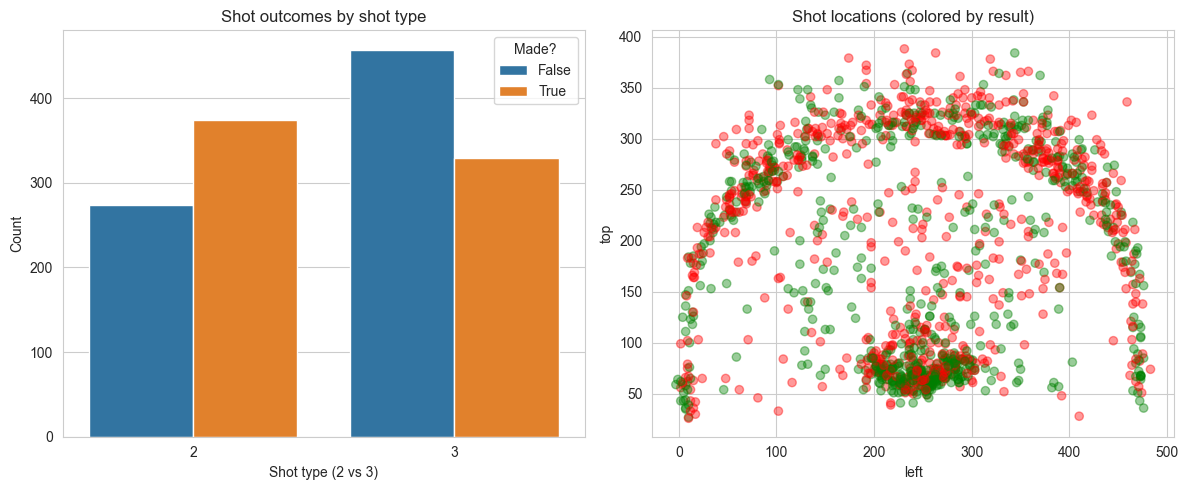

In [11]:

# Visualizations to support the deck
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart: make/miss by shot type
sns.countplot(data=df, x='shot_type', hue='result', ax=axes[0])
axes[0].set_title('Shot outcomes by shot type')
axes[0].set_xlabel('Shot type (2 vs 3)')
axes[0].set_ylabel('Count')
axes[0].legend(title='Made?')

# Scatter: court positions colored by result
colors = {True: 'green', False: 'red'}
axes[1].scatter(df['left'], df['top'], c=df['result'].map(colors), alpha=0.4)
axes[1].set_title('Shot locations (colored by result)')
axes[1].set_xlabel('left')
axes[1].set_ylabel('top')

plt.tight_layout()
plt.show()



## Slide-ready figures and numbers
Use the tables and numbers printed above directly in the slides:
- Overall Shooting Statistics: use the summary table (P(Make), P(Miss), P(Three), P(Two)).
- Probabilities: plug the binomial outputs; list assumptions (independence, constant p, fixed n).
- Conditional Probabilities - Future: use the Bayes table for P(M|T3), P(L|T3), P(M|T2), P(L|T2).
- Conditional Probabilities - Retrospective: use P(T3|M) and P(T2|M) with Bayes framing.

Each section already includes V&V notes so you can cite sanity checks in the presentation if asked.
